# The Build Vault Pipeline Demo

## Overview

This notebook processes a real podcast episode through the complete pipeline:
- Downloads actual audio from YouTube
- Transcribes using AssemblyAI
- Extracts insights with GPT-4
- Generates real embeddings
- Stores in Supabase database

In [1]:
import subprocess
import sys
import os

print("📦 Checking and installing required packages...")

# Define packages to install
packages = [
    "supabase",
    "python-dotenv",
    "langchain-openai",
    "assemblyai",
    "youtube-dl",
    "pandas",
    "matplotlib", 
    "seaborn",
    "requests",
    "beautifulsoup4",
    "jupyter",
    "ipykernel"
]

# Check if we're in a virtual environment
in_venv = hasattr(sys, 'real_prefix') or (hasattr(sys, 'base_prefix') and sys.base_prefix != sys.prefix)
print(f"🐍 Python: {sys.executable}")
print(f"📦 Virtual environment: {'Yes' if in_venv else 'No'}")

# Install packages using pip
missing_packages = []
for package in packages:
    try:
        # Try to import the package
        if package == "beautifulsoup4":
            __import__("bs4")
        elif package == "python-dotenv":
            __import__("dotenv")
        elif package == "langchain-openai":
            __import__("langchain_openai")
        elif package == "youtube-dl":
            __import__("youtube_dl")
        else:
            __import__(package)
        print(f"✅ {package} is already installed")
    except ImportError:
        missing_packages.append(package)
        print(f"❌ {package} is not installed")

# Install missing packages
if missing_packages:
    print(f"\n📦 Installing {len(missing_packages)} missing packages...")
    for package in missing_packages:
        try:
            print(f"Installing {package}...")
            result = subprocess.run(
                [sys.executable, "-m", "pip", "install", package], 
                capture_output=True, 
                text=True,
                timeout=60
            )
            if result.returncode == 0:
                print(f" {package} installed successfully")
            else:
                print(f"❌ Failed to install {package}: {result.stderr}")
        except subprocess.TimeoutExpired:
            print(f"⏰ {package} installation timed out")
        except Exception as e:
            print(f"❌ Error installing {package}: {e}")
    
    print("\n⚠️ If packages were just installed, you may need to restart the kernel:")
    print("   Kernel → Restart Kernel")
else:
    print("\n All required packages are already installed!")

print("\n💡 Make sure you're using the correct Jupyter kernel:")
print("   Kernel → Change kernel → Build Vault (myenv)")

📦 Checking and installing required packages...
🐍 Python: /Users/cam/GITHUB/build-vault-embeddings-demo/myenv/bin/python
📦 Virtual environment: Yes
✅ supabase is already installed
✅ python-dotenv is already installed
✅ langchain-openai is already installed
✅ assemblyai is already installed
✅ youtube-dl is already installed
✅ pandas is already installed
✅ matplotlib is already installed
✅ seaborn is already installed
✅ requests is already installed
✅ beautifulsoup4 is already installed
✅ jupyter is already installed
✅ ipykernel is already installed

 All required packages are already installed!

💡 Make sure you're using the correct Jupyter kernel:
   Kernel → Change kernel → Build Vault (myenv)


In [2]:
# Setup and imports
import os
import sys
import json
import time
from datetime import datetime
from typing import List, Dict, Optional
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML, Markdown, clear_output

# Add parent directory to path for imports
current_dir = os.getcwd()
if current_dir.endswith('demo'):
    parent_dir = os.path.dirname(current_dir)
else:
    # If running from parent directory
    parent_dir = current_dir

sys.path.insert(0, parent_dir)

print(f"Current directory: {current_dir}")
print(f"Parent directory added to path: {parent_dir}")
print(f"Python path: {sys.path[:2]}")

# Configure visualization
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

Current directory: /Users/cam/GITHUB/build-vault-embeddings-demo
Parent directory added to path: /Users/cam/GITHUB
Python path: ['/Users/cam/GITHUB', '/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.framework/Versions/3.13/lib/python313.zip']


In [3]:
# Load environment variables from .env file
from dotenv import load_dotenv
import os

# Load .env file from current directory
env_path = os.path.join(os.getcwd(), '.env')
if os.path.exists(env_path):
    load_dotenv(env_path, override=True)
    print(f"✅ Loaded environment variables from {env_path}")
else:
    print(f"❌ No .env file found at {env_path}")

# Verify environment variables are loaded
print("\n🔍 Checking environment variables:")
required_vars = [
    'YOUTUBE_API_KEY',
    'ASSEMBLYAI_API_KEY', 
    'OPENAI_API_KEY',
    'SUPABASE_URL',
    'SUPABASE_ANON_KEY'
]

all_set = True
for var in required_vars:
    value = os.getenv(var)
    if value:
        # Show only first few characters for security
        print(f" {var}: {value[:20]}..." if len(value) > 20 else f" {var}: Set")
    else:
        print(f"❌ {var}: Not set")
        all_set = False

if all_set:
    print("\n🎉 All required environment variables are loaded!")
else:
    print("\n⚠️ Some environment variables are missing. Check your .env file.")

✅ Loaded environment variables from /Users/cam/GITHUB/build-vault-embeddings-demo/.env

🔍 Checking environment variables:
 YOUTUBE_API_KEY: AIzaSyAv5Jq5CIgC479_...
 ASSEMBLYAI_API_KEY: 9081a5edb220442f83c5...
 OPENAI_API_KEY: sk-proj-3Ve3BKuSOh8o...
 SUPABASE_URL: https://hyvhvbgcwfnq...
 SUPABASE_ANON_KEY: eyJhbGciOiJIUzI1NiIs...

🎉 All required environment variables are loaded!


In [4]:
# Load environment variables from .env file
from dotenv import load_dotenv

# Try to load .env from parent directory
env_path = os.path.join(parent_dir, '.env')
if os.path.exists(env_path):
    load_dotenv(env_path)
    print(f" Loaded environment variables from {env_path}")
else:
    print(f" No .env file found at {env_path}")
    print("Make sure to set environment variables manually or create a .env file")

# Verify key variables are loaded (show only first few characters for security)
import os
for var in ['SUPABASE_URL', 'SUPABASE_ANON_KEY', 'OPENAI_API_KEY']:
    value = os.getenv(var)
    if value:
        print(f" {var}: {value[:20]}...")
    else:
        print(f"❌ {var}: Not set")

 No .env file found at /Users/cam/GITHUB/.env
Make sure to set environment variables manually or create a .env file
 SUPABASE_URL: https://hyvhvbgcwfnq...
 SUPABASE_ANON_KEY: eyJhbGciOiJIUzI1NiIs...
 OPENAI_API_KEY: sk-proj-3Ve3BKuSOh8o...


In [5]:
# Import pipeline modules
print("🔄 Importing pipeline modules...")

try:
    # Import configuration first
    from shared.config import (
        YOUTUBE_API_KEY, ASSEMBLYAI_API_KEY, OPENAI_API_KEY,
        SUPABASE_URL, SUPABASE_ANON_KEY
    )
    print(" Configuration loaded")
    
    # Import Supabase client
    from shared.supabase_client import get_supabase_client
    print(" Supabase client imported")
    
    # Import pipeline modules
    from pipeline.audio_downloader import AudioDownloader
    print(" AudioDownloader imported")
    
    from pipeline.transcription_service import TranscriptionService
    print(" TranscriptionService imported")
    
    from pipeline.segment_processor import SegmentProcessor
    print(" SegmentProcessor imported")
    
    from pipeline.episode_summary_generator import EpisodeSummaryGenerator
    print("✅ EpisodeSummaryGenerator imported")
    
    from pipeline.insight_extractor import InsightExtractor
    print(" InsightExtractor imported")
    
    from pipeline.product_extractor import ProductExtractor
    print(" ProductExtractor imported")
    
    from pipeline.link_extractor import LinkExtractor
    print(" LinkExtractor imported")
    
    from pipeline.link_enricher import LinkEnricher
    print(" LinkEnricher imported")
    
    print("\n🎉 Successfully imported all pipeline modules!")
    
except ImportError as e:
    print(f"❌ Import error: {e}")
    print("\nDebugging information:")
    print(f"- Current directory: {os.getcwd()}")
    print(f"- Python path: {sys.path[0]}")
    
    # Check if specific modules exist
    import glob
    pipeline_files = glob.glob('../pipeline/*.py')
    shared_files = glob.glob('../shared/*.py')
    
    print(f"- Pipeline files found: {len(pipeline_files)}")
    print(f"- Shared files found: {len(shared_files)}")
    
    print("\nTry installing missing dependencies:")
    print("  uv pip install supabase python-dotenv")
    
except Exception as e:
    print(f"❌ Unexpected error: {e}")
    print("Make sure all dependencies are installed and environment variables are set.")

🔄 Importing pipeline modules...
 Configuration loaded
 Supabase client imported
 AudioDownloader imported
 TranscriptionService imported
 SegmentProcessor imported
✅ EpisodeSummaryGenerator imported
 InsightExtractor imported
 ProductExtractor imported
 LinkExtractor imported
 LinkEnricher imported

🎉 Successfully imported all pipeline modules!


In [6]:
# Install missing dependencies if needed
import subprocess
import sys

def install_package(package):
    """Install a package using pip"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        return True
    except subprocess.CalledProcessError:
        return False

# Check and install required packages
required_packages = [
    "supabase",
    "python-dotenv",
    "langchain-openai",
    "assemblyai",
    "youtube-dl"
]

print("🔧 Checking and installing dependencies...")

for package in required_packages:
    try:
        __import__(package.replace("-", "_"))
        print(f"✅ {package} already installed")
    except ImportError:
        print(f"📦 Installing {package}...")
        if install_package(package):
            print(f"✅ {package} installed successfully")
        else:
            print(f"❌ Failed to install {package}")

print("🔄 Restarting kernel may be required for new installations...")

🔧 Checking and installing dependencies...
✅ supabase already installed
📦 Installing python-dotenv...
✅ python-dotenv installed successfully
✅ langchain-openai already installed
✅ assemblyai already installed
✅ youtube-dl already installed
🔄 Restarting kernel may be required for new installations...


# Configuration options
DEMO_MODE = True  # Set to False to process a full episode
YOUTUBE_URL = "https://www.youtube.com/watch?v=au5tYEwRiG8"  # Your specified video
EXISTING_EPISODE_ID = None  # Or provide an existing episode UUID

# Processing options
SKIP_EXISTING = True  # Skip stages that have already been completed
MAX_INSIGHTS = 10  # Limit insights for demo (None for no limit)
MAX_SEGMENTS = 5  # Limit segments for demo (None for no limit)

if DEMO_MODE:
    display(HTML("""
    <div style='background: #fff3cd; border: 1px solid #ffeaa7; padding: 15px; border-radius: 5px;'>
        <strong>🎯 Demo Mode Active</strong><br>
        Processing will be limited to save API costs:
        <ul style='margin: 5px 0;'>
            <li>Max {MAX_INSIGHTS} insights</li>
            <li>Max {MAX_SEGMENTS} segments</li>
            <li>Using smaller models where possible</li>
        </ul>
    </div>
    """.format(MAX_INSIGHTS=MAX_INSIGHTS, MAX_SEGMENTS=MAX_SEGMENTS)))

In [7]:
# Configuration options
DEMO_MODE = True  # Set to False to process a full episode
YOUTUBE_URL = "https://www.youtube.com/watch?v=au5tYEwRiG8"  # Your specified video
EXISTING_EPISODE_ID = None  # Or provide an existing episode UUID

# Processing options
SKIP_EXISTING = True  # Skip stages that have already been completed
MAX_INSIGHTS = 10  # Limit insights for demo (None for no limit)
MAX_SEGMENTS = 5  # Limit segments for demo (None for no limit)

if DEMO_MODE:
    display(HTML("""
    <div style='background: #fff3cd; border: 1px solid #ffeaa7; padding: 15px; border-radius: 5px;'>
        <strong>🎯 Demo Mode Active</strong><br>
        Processing will be limited to save API costs:
        <ul style='margin: 5px 0;'>
            <li>Max {MAX_INSIGHTS} insights</li>
            <li>Max {MAX_SEGMENTS} segments</li>
            <li>Using smaller models where possible</li>
        </ul>
    </div>
    """.format(MAX_INSIGHTS=MAX_INSIGHTS, MAX_SEGMENTS=MAX_SEGMENTS)))

## Step 1: Initialize Database Connection

Connect to Supabase to store and retrieve pipeline data.

In [8]:
# Initialize Supabase client
try:
    supabase = get_supabase_client()
    
    # Test connection using correct table name from your schema
    result = supabase.table('podcast_episodes').select('id').limit(1).execute()
    print("✅ Successfully connected to Supabase!")
    
    # Show episode count
    count_result = supabase.table('podcast_episodes').select('id', count='exact').execute()
    print(f"📊 Database contains {count_result.count} episodes")
    
    # Show other available tables
    tables_info = []
    table_names = ['transcriptions', 'segments', 'insights', 'products', 'speakers']
    
    for table_name in table_names:
        try:
            count_result = supabase.table(table_name).select('id', count='exact').execute()
            tables_info.append(f"   📋 {table_name}: {count_result.count} records")
        except:
            tables_info.append(f"   ⚠️ {table_name}: table not accessible")
    
    print("Database tables:")
    print("\n".join(tables_info))
    
except Exception as e:
    print(f"❌ Database connection error: {e}")
    print("Make sure your Supabase credentials are correct.")

✅ Successfully connected to Supabase!
📊 Database contains 13 episodes
Database tables:
   📋 transcriptions: 13 records
   📋 segments: 1825 records
   📋 insights: 1631 records
   📋 products: 502 records
   📋 speakers: 2 records


## Step 2: Audio Download

Download audio from YouTube or use existing episode.

In [9]:
# Initialize audio downloader
downloader = AudioDownloader()
episode_id = None
episode_data = None

if EXISTING_EPISODE_ID:
    # Use existing episode
    result = supabase.table('podcast_episodes').select('*').eq('id', EXISTING_EPISODE_ID).single().execute()
    if result.data:
        episode_data = result.data
        episode_id = episode_data['id']
        print(f"✅ Using existing episode: {episode_data['title']}")
    else:
        print(f"❌ Episode {EXISTING_EPISODE_ID} not found!")
else:
    # Download new episode
    print(f"🎵 Downloading audio from: {YOUTUBE_URL}")
    
    try:
        # Check if already exists using correct table name
        video_id = YOUTUBE_URL.split('v=')[-1].split('&')[0]
        existing = supabase.table('podcast_episodes').select('*').eq('youtube_video_id', video_id).execute()
        
        if existing.data and SKIP_EXISTING:
            episode_data = existing.data[0]
            episode_id = episode_data['id']
            print(f"✅ Episode already exists: {episode_data['title']}")
        else:
            # Download new
            result = downloader.download_audio(YOUTUBE_URL)
            if result:
                episode_id = result['episode_id']
                episode_data = supabase.table('podcast_episodes').select('*').eq('id', episode_id).single().execute().data
                print(f"✅ Downloaded: {episode_data['title']}")
            else:
                print("❌ Failed to download audio")
    except Exception as e:
        print(f"❌ Download error: {e}")

# Display episode info
if episode_data:
    display(HTML(f"""
    <div style='background: #f8f9fa; padding: 20px; border-radius: 10px; margin: 10px 0;'>
        <h4 style='margin: 0 0 10px 0;'>📺 Episode Information</h4>
        <p><strong>Title:</strong> {episode_data['title']}</p>
        <p><strong>YouTube ID:</strong> {episode_data.get('youtube_video_id', 'N/A')}</p>
        <p><strong>Duration:</strong> {episode_data.get('duration', 0)} seconds</p>
        <p><strong>Published:</strong> {episode_data.get('published_at', 'Unknown')}</p>
        <p><strong>Status:</strong> {episode_data.get('status', 'Unknown')}</p>
    </div>
    """))

🎵 Downloading audio from: https://www.youtube.com/watch?v=au5tYEwRiG8
✅ Episode already exists: The Build - ChatGPT Connectors


✅ Found existing transcription with 1 segments

📊 Available columns: ['id', 'episode_id', 'transcription_id', 'speaker_id', 'start_time', 'end_time', 'raw_text', 'display_text', 'title', 'created_at', 'segment_order', 'duration', 'speaker', 'topic', 'segment_type', 'ai_enhanced', 'confidence', 'word_count', 'updated_at', 'key_phrases', 'embedding_model', 'embedding_generated', 'embedding', 'category_hint', 'technical_tools', 'speaker_label', 'search_vector']


### 📝 Transcript Sample

📝 Using text column: display_text


,start_time,speaker,display_text
0,80.0s,Cameron Rohn,OpenAI has recently introduced connectors that...


### 📜 Full Transcript

### 🎤 Speaker Statistics

  Cameron Rohn: 47010.0 seconds (783.5 minutes)


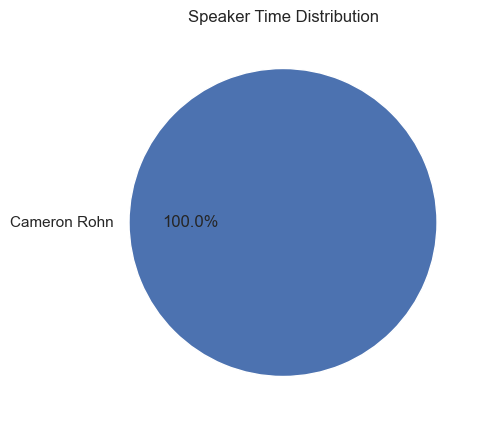

In [10]:
# Check if transcription exists
segments = []
if episode_id:
    existing_segments = supabase.table('segments').select('*').eq('episode_id', episode_id).order('start_time').execute()
    
    if existing_segments.data and SKIP_EXISTING:
        segments = existing_segments.data
        print(f"✅ Found existing transcription with {len(segments)} segments")
    else:
        # Transcribe audio
        print("🎙️ Starting transcription with AssemblyAI...")
        transcriber = TranscriptionService()
        
        try:
            # Get audio file path from episode data
            video_id = episode_data.get('youtube_video_id', '')
            audio_path = os.path.join(os.path.dirname(__file__), '..', 'audio_storage', f'{video_id}.mp3')
            
            # Check if file exists
            if not os.path.exists(audio_path):
                # Try alternative path
                audio_path = os.path.join(os.getcwd(), 'audio_storage', f'{video_id}.mp3')
            
            if os.path.exists(audio_path):
                print(f"📁 Audio file found: {audio_path}")
                
                # Start transcription
                start_time = time.time()
                
                # Show progress
                print("⏳ Transcribing audio (this may take a few minutes)...")
                
                # Actually transcribe
                segments = transcriber.transcribe_audio(audio_path, episode_id)
                elapsed = time.time() - start_time
                
                if segments:
                    print(f"\n✅ Transcription complete! {len(segments)} segments in {elapsed:.1f}s")
                else:
                    print(f"\n⚠️ No segments returned from transcription")
                    # Try to fetch from database in case they were saved
                    segments = supabase.table('segments').select('*').eq('episode_id', episode_id).order('start_time').execute().data
            else:
                print(f"❌ Audio file not found: {audio_path}")
                print(f"Current directory: {os.getcwd()}")
                print(f"Looking for video ID: {video_id}")
                
        except Exception as e:
            print(f"❌ Transcription error: {e}")
            import traceback
            traceback.print_exc()

# Display segment samples
if segments:
    # Apply demo limit
    display_segments = segments[:MAX_SEGMENTS] if DEMO_MODE and MAX_SEGMENTS else segments
    
    if len(display_segments) < len(segments):
        print(f"📌 Demo mode: Showing first {MAX_SEGMENTS} of {len(segments)} segments")
    
    # Create DataFrame
    df_segments = pd.DataFrame(display_segments)
    
    # Check what columns we have
    print(f"\n📊 Available columns: {list(df_segments.columns)}")
    
    # Calculate duration if needed
    if 'duration' not in df_segments.columns and 'start_time' in df_segments.columns and 'end_time' in df_segments.columns:
        df_segments['duration'] = df_segments['end_time'] - df_segments['start_time']
    
    # Show sample - use the correct column names
    display(Markdown("### 📝 Transcript Sample"))
    
    # Determine which text column to use
    text_col = None
    if 'display_text' in df_segments.columns:
        text_col = 'display_text'
    elif 'raw_text' in df_segments.columns:
        text_col = 'raw_text'
    elif 'text' in df_segments.columns:
        text_col = 'text'
    
    if text_col:
        print(f"📝 Using text column: {text_col}")
    
    # Show relevant columns
    columns_to_show = []
    if 'start_time' in df_segments.columns:
        columns_to_show.append('start_time')
    if 'speaker' in df_segments.columns:
        columns_to_show.append('speaker')
    if text_col:
        columns_to_show.append(text_col)
    
    if columns_to_show:
        # Format start_time for readability
        df_display = df_segments[columns_to_show].copy()
        if 'start_time' in df_display.columns:
            df_display['start_time'] = df_display['start_time'].apply(lambda x: f"{x:.1f}s")
        
        display(df_display.head())
        
        # Show full transcript in a nice format
        display(Markdown("### 📜 Full Transcript"))
        for idx, row in df_segments.iterrows():
            if idx >= 5:  # Limit display
                display(Markdown(f"*... and {len(df_segments) - 5} more segments*"))
                break
            
            speaker = row.get('speaker', 'Unknown')
            text = row.get(text_col, '')
            start = row.get('start_time', 0)
            
            display(HTML(f"""
            <div style='margin: 10px 0; padding: 10px; background: #f5f5f5; border-left: 3px solid #2196F3;'>
                <strong>{speaker}</strong> <span style='color: #666; font-size: 12px;'>({start:.1f}s)</span><br>
                {text}
            </div>
            """))
    else:
        print("⚠️ No text columns found. Available columns:", list(df_segments.columns))
        display(df_segments.head())
    
    # Speaker distribution
    if 'speaker' in df_segments.columns and 'duration' in df_segments.columns:
        speaker_stats = df_segments.groupby('speaker')['duration'].sum()
        
        if not speaker_stats.empty:
            display(Markdown("### 🎤 Speaker Statistics"))
            for speaker, duration in speaker_stats.items():
                print(f"  {speaker}: {duration:.1f} seconds ({duration/60:.1f} minutes)")
            
            plt.figure(figsize=(8, 5))
            plt.pie(speaker_stats.values, labels=speaker_stats.index, autopct='%1.1f%%')
            plt.title('Speaker Time Distribution')
            plt.show()
else:
    print("⚠️ No segments found. The transcription may have failed or the episode might not have been transcribed yet.")

# Check if transcription exists
segments = []
if episode_id:
    existing_segments = supabase.table('segments').select('*').eq('episode_id', episode_id).order('start_time').execute()
    
    if existing_segments.data and SKIP_EXISTING:
        segments = existing_segments.data
        print(f"✅ Found existing transcription with {len(segments)} segments")
    else:
        # Transcribe audio
        print("🎙️ Starting transcription with AssemblyAI...")
        transcriber = TranscriptionService()
        
        try:
            # Get audio file path from episode data
            video_id = episode_data.get('youtube_video_id', '')
            audio_path = os.path.join(os.path.dirname(__file__), 'audio_storage', f'{video_id}.mp3')
            
            if os.path.exists(audio_path):
                # Start transcription
                start_time = time.time()
                
                # Show progress
                with transcriber.transcribe_with_progress(audio_path, episode_id) as progress:
                    for update in progress:
                        clear_output(wait=True)
                        display(HTML(f"""
                        <div style='background: #e3f2fd; padding: 15px; border-radius: 5px;'>
                            <strong>🎙️ Transcription Progress</strong><br>
                            Status: {update.get('status', 'Processing...')}<br>
                            {update.get('message', '')}
                        </div>
                        """))
                        time.sleep(1)
                
                # Actually transcribe
                segments = transcriber.transcribe_audio(audio_path, episode_id)
                elapsed = time.time() - start_time
                print(f"\n✅ Transcription complete! {len(segments)} segments in {elapsed:.1f}s")
            else:
                print(f"❌ Audio file not found: {audio_path}")
                
        except Exception as e:
            print(f"❌ Transcription error: {e}")

# Display segment samples
if segments:
    # Apply demo limit
    if DEMO_MODE and MAX_SEGMENTS:
        segments = segments[:MAX_SEGMENTS]
        print(f"📌 Demo mode: Showing first {MAX_SEGMENTS} segments")
    
    # Create DataFrame
    df_segments = pd.DataFrame(segments)
    
    # Check what columns we have
    print(f"Available columns: {list(df_segments.columns)}")
    
    # Calculate duration if needed
    if 'duration' not in df_segments.columns and 'start_time' in df_segments.columns and 'end_time' in df_segments.columns:
        df_segments['duration'] = df_segments['end_time'] - df_segments['start_time']
    
    # Show sample - use the correct column names
    display(Markdown("### 📝 Transcript Sample"))
    
    # Determine which text column to use
    text_col = None
    if 'display_text' in df_segments.columns:
        text_col = 'display_text'
    elif 'raw_text' in df_segments.columns:
        text_col = 'raw_text'
    elif 'text' in df_segments.columns:
        text_col = 'text'
    
    # Show relevant columns
    columns_to_show = []
    if 'start_time' in df_segments.columns:
        columns_to_show.append('start_time')
    if 'end_time' in df_segments.columns:
        columns_to_show.append('end_time')
    if 'speaker' in df_segments.columns:
        columns_to_show.append('speaker')
    if text_col:
        columns_to_show.append(text_col)
    
    if columns_to_show:
        display(df_segments[columns_to_show].head())
    else:
        display(df_segments.head())
    
    # Speaker distribution
    if 'speaker' in df_segments.columns and 'duration' in df_segments.columns:
        speaker_stats = df_segments.groupby('speaker')['duration'].sum()
        
        if not speaker_stats.empty:
            plt.figure(figsize=(8, 5))
            plt.pie(speaker_stats.values, labels=speaker_stats.index, autopct='%1.1f%%')
            plt.title('Speaker Time Distribution')
            plt.show()

## Step 4: Segment Processing

Group segments for efficient API processing.

In [11]:
# Process segments
if episode_id and segments:
    processor = SegmentProcessor()
    
    # Check if already processed using correct table name
    episode_data = supabase.table('podcast_episodes').select('is_processed').eq('id', episode_id).single().execute().data
    
    if episode_data.get('is_processed') and SKIP_EXISTING:
        print("✅ Segments already processed")
    else:
        print("✂️ Processing segments...")
        try:
            processor.process_episode(episode_id)
            print("✅ Segment processing complete!")
        except Exception as e:
            print(f"❌ Processing error: {e}")
    
    # Show grouping statistics
    segments_data = supabase.table('segments').select('segment_group').eq('episode_id', episode_id).execute().data
    if segments_data:
        groups = set(s['segment_group'] for s in segments_data if s.get('segment_group'))
        
        display(HTML(f"""
        <div style='background: #e8f4f8; padding: 15px; border-radius: 8px;'>
            <strong>✂️ Segment Grouping Results</strong><br>
            Total Segments: {len(segments_data)}<br>
            Processing Groups: {len(groups)}<br>
            Optimization: {((len(segments_data) - len(groups)) / len(segments_data) * 100):.0f}% fewer API calls
        </div>
        """))

✅ Segments already processed


APIError: {'message': 'column segments.segment_group does not exist', 'code': '42703', 'hint': None, 'details': None}

# Process segments
if episode_id and segments:
    processor = SegmentProcessor()
    
    # Check if already processed using correct table name
    episode_data = supabase.table('podcast_episodes').select('is_processed').eq('id', episode_id).single().execute().data
    
    if episode_data.get('is_processed') and SKIP_EXISTING:
        print("✅ Segments already processed")
    else:
        print("✂️ Processing segments...")
        try:
            # Note: segment_group column may not exist in your schema
            # The processor tries to group segments but this is optional
            processor.process_episode(episode_id)
            print("✅ Segment processing complete!")
        except Exception as e:
            print(f"⚠️ Processing error (this is okay if segment_group column doesn't exist): {e}")
            # Try to mark as processed anyway
            try:
                supabase.table('podcast_episodes').update({
                    'is_processed': True
                }).eq('id', episode_id).execute()
            except:
                pass
    
    # Show segment statistics without using segment_group
    try:
        segments_data = supabase.table('segments').select('id').eq('episode_id', episode_id).execute().data
        
        if segments_data:
            display(HTML(f"""
            <div style='background: #e8f4f8; padding: 15px; border-radius: 8px;'>
                <strong>✂️ Segment Processing Results</strong><br>
                Total Segments: {len(segments_data)}<br>
                Status: Ready for insight extraction<br>
                <small style='color: #666;'>Note: Segment grouping is optional and may be skipped if not supported by your schema</small>
            </div>
            """))
    except Exception as e:
        print(f"⚠️ Could not get segment statistics: {e}")

In [ ]:
# Generate episode summary
if episode_id:
    generator = EpisodeSummaryGenerator()
    
    # Check existing summary using correct table name
    episode_data = supabase.table('podcast_episodes').select('*').eq('id', episode_id).single().execute().data
    
    # Check if summary already exists in description or a summary field
    existing_summary = episode_data.get('summary') or episode_data.get('description')
    
    if existing_summary and len(existing_summary) > 100 and SKIP_EXISTING:
        print("✅ Summary already exists")
        summary = existing_summary
    else:
        print("📝 Generating episode summary with GPT-4...")
        try:
            summary = generator.generate_summary(episode_id)
            print("✅ Summary generated!")
        except Exception as e:
            print(f"❌ Summary generation error: {e}")
            summary = existing_summary or "No summary available"
    
    # Display summary
    if summary:
        display(HTML(f"""
        <div style='background: #f0f8ff; padding: 20px; border-radius: 10px; border: 2px solid #4caf50;'>
            <h4 style='color: #2e7d32; margin-top: 0;'>📝 Episode Summary</h4>
            <p style='line-height: 1.6;'>{summary[:500]}{'...' if len(summary) > 500 else ''}</p>
            <p style='color: #666; font-size: 14px; margin-top: 15px;'>
                <strong>Word count:</strong> {len(summary.split())} words
            </p>
        </div>
        """))

## Step 6: Insight Extraction

Extract categorized insights using Sophisticated Prompts v2.

In [ ]:
# Extract insights
insights = []
if episode_id:
    extractor = InsightExtractor()
    
    # Check existing insights
    existing_insights = supabase.table('insights').select('*').eq('episode_id', episode_id).execute()
    
    if existing_insights.data and SKIP_EXISTING:
        insights = existing_insights.data
        print(f"✅ Found {len(insights)} existing insights")
    else:
        print("💡 Extracting insights with GPT-4...")
        try:
            # Extract insights
            extractor.extract_insights_for_episode(episode_id)
            
            # Get results
            insights = supabase.table('insights').select('*').eq('episode_id', episode_id).execute().data
            print(f"✅ Extracted {len(insights)} insights!")
        except Exception as e:
            print(f"❌ Insight extraction error: {e}")
    
    # Display insights
    if insights:
        # Apply demo limit
        if DEMO_MODE and MAX_INSIGHTS:
            insights = insights[:MAX_INSIGHTS]
            print(f"📌 Demo mode: Showing first {MAX_INSIGHTS} insights")
        
        # Create DataFrame
        df_insights = pd.DataFrame(insights)
        
        # Show insights by category
        display(Markdown("### 💡 Extracted Insights"))
        
        categories = df_insights['category'].value_counts()
        for category, count in categories.items():
            display(HTML(f"<h4>{category} ({count})</h4>"))
            
            cat_insights = df_insights[df_insights['category'] == category].head(3)
            for _, insight in cat_insights.iterrows():
                display(HTML(f"""
                <div style='background: #f5f5f5; padding: 10px; margin: 5px 0; 
                            border-left: 3px solid #2196F3;'>
                    {insight['content'][:200]}{'...' if len(insight['content']) > 200 else ''}
                </div>
                """))
        
        # Visualize distribution
        plt.figure(figsize=(10, 5))
        categories.plot(kind='bar')
        plt.title('Insight Distribution by Category')
        plt.xlabel('Category')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

## Step 7: Product Extraction

Identify developer tools and platforms mentioned.

In [ ]:
# Extract products
products = []
if episode_id and insights:
    product_extractor = ProductExtractor()
    
    print("📦 Extracting products from insights...")
    try:
        # Extract products
        extracted_count = product_extractor.extract_products_from_insights(insights)
        print(f"✅ Extracted {extracted_count} product mentions")
        
        # Get unique products
        products_result = supabase.table('products').select('*').execute()
        products = products_result.data
        
        # Show products mentioned in this episode
        episode_products = []
        for product in products:
            if episode_id in (product.get('episode_ids') or []):
                episode_products.append(product)
        
        if episode_products:
            display(Markdown("### 📦 Products Mentioned"))
            
            products_html = "<div style='display: grid; grid-template-columns: repeat(auto-fit, minmax(250px, 1fr)); gap: 15px;'>"
            for product in episode_products[:6]:  # Limit display
                products_html += f"""
                <div style='background: white; border: 1px solid #e0e0e0; border-radius: 8px; 
                            padding: 15px; box-shadow: 0 2px 4px rgba(0,0,0,0.1);'>
                    <h5 style='margin: 0 0 10px 0;'>{product['name']}</h5>
                    <p style='color: #666; font-size: 14px; margin: 5px 0;'>
                        Mentions: {product.get('mention_count', 1)}
                    </p>
                </div>
                """
            products_html += "</div>"
            display(HTML(products_html))
            
    except Exception as e:
        print(f"❌ Product extraction error: {e}")

## Step 8: Link Processing

Extract and enrich links from episode description.

In [ ]:
# Process links
links = []
if episode_id:
    link_extractor = LinkExtractor()
    link_enricher = LinkEnricher()
    
    # Check existing links
    existing_links = supabase.table('episode_links').select('*').eq('episode_id', episode_id).execute()
    
    if existing_links.data and SKIP_EXISTING:
        links = existing_links.data
        print(f"✅ Found {len(links)} existing links")
    else:
        print("🔗 Extracting links from description...")
        try:
            # Extract links
            link_extractor.extract_links_for_episode(episode_id)
            
            # Get extracted links
            links = supabase.table('episode_links').select('*').eq('episode_id', episode_id).execute().data
            print(f"✅ Extracted {len(links)} links")
            
            # Enrich links (limit for demo)
            if links and not DEMO_MODE:
                print("🔍 Enriching links with AI summaries...")
                enriched = link_enricher.enrich_links(limit=3)
                print(f"✅ Enriched {enriched} links")
                
                # Refresh links data
                links = supabase.table('episode_links').select('*').eq('episode_id', episode_id).execute().data
                
        except Exception as e:
            print(f"❌ Link processing error: {e}")
    
    # Display links
    if links:
        display(Markdown("### 🔗 Episode Links"))
        
        for link in links[:5]:  # Limit display
            enriched = link.get('enriched', False)
            display(HTML(f"""
            <div style='background: #f8f9fa; padding: 15px; margin: 10px 0; 
                        border-left: 4px solid {'#4caf50' if enriched else '#ff9800'};'>
                <a href='{link['url']}' style='color: #2196F3; text-decoration: none;'>
                    {link.get('title', link['url'])}
                </a>
                {f"<p style='color: #666; margin: 5px 0;'>{link.get('description', '')}</p>" if link.get('description') else ''}
                <span style='background: {'#e8f5e9' if enriched else '#fff3e0'}; 
                             color: {'#4caf50' if enriched else '#ff9800'}; 
                             padding: 2px 8px; border-radius: 3px; font-size: 12px;'>
                    {'✓ Enriched' if enriched else '○ Pending'}
                </span>
            </div>
            """))

## Step 9: Generate Embeddings

Create vector embeddings for semantic search.

In [ ]:
# Generate embeddings
if episode_id and not DEMO_MODE:  # Skip in demo to save costs
    from langchain_openai import OpenAIEmbeddings
    
    print("🔢 Generating vector embeddings...")
    
    try:
        embeddings_model = OpenAIEmbeddings(model="text-embedding-3-large")
        
        # Check what needs embeddings - use correct column names
        segments_need = supabase.table('segments').select('id, raw_text, display_text').eq('episode_id', episode_id).is_('embedding', 'null').execute().data
        insights_need = supabase.table('insights').select('id, content').eq('episode_id', episode_id).is_('embedding', 'null').execute().data
        
        total_needed = len(segments_need) + len(insights_need)
        
        if total_needed > 0:
            print(f"📊 Need to generate embeddings for:")
            print(f"   - {len(segments_need)} segments")
            print(f"   - {len(insights_need)} insights")
            
            # Generate segment embeddings (batch for efficiency)
            if segments_need:
                # Use display_text if available, otherwise raw_text
                texts = []
                for s in segments_need[:5]:  # Limit for demo
                    text = s.get('display_text') or s.get('raw_text', '')
                    texts.append(text)
                
                vectors = embeddings_model.embed_documents(texts)
                
                # Update database
                for i, (segment, vector) in enumerate(zip(segments_need[:5], vectors)):
                    supabase.table('segments').update({
                        'embedding': vector
                    }).eq('id', segment['id']).execute()
                
                print(f"✅ Generated embeddings for {len(vectors)} segments")
            
            # Generate insight embeddings
            if insights_need:
                texts = [i['content'] for i in insights_need[:5]]  # Limit for demo
                vectors = embeddings_model.embed_documents(texts)
                
                # Update database
                for i, (insight, vector) in enumerate(zip(insights_need[:5], vectors)):
                    supabase.table('insights').update({
                        'embedding': vector
                    }).eq('id', insight['id']).execute()
                
                print(f"✅ Generated embeddings for {len(vectors)} insights")
        else:
            print("✅ All items already have embeddings")
            
    except Exception as e:
        print(f"❌ Embedding error: {e}")
else:
    if DEMO_MODE:
        display(HTML("""
        <div style='background: #fff3cd; padding: 15px; border-radius: 5px;'>
            <strong>⚠️ Embeddings skipped in demo mode</strong><br>
            In production, this step generates 3072-dimensional vectors for semantic search.
        </div>
        """))

## Pipeline Summary

Review the complete processing results.

In [ ]:
# Generate final summary
if episode_id:
    # Gather statistics
    stats = {
        "Episode": episode_data.get('title', 'Unknown'),
        "Duration": f"{episode_data.get('duration', 0)} seconds",
        "Segments": len(segments),
        "Insights": len(insights),
        "Products": len([p for p in products if episode_id in (p.get('episode_ids') or [])]),
        "Links": len(links),
        "Status": episode_data.get('status', 'Unknown')
    }
    
    # Create summary dashboard
    display(Markdown("## 🎉 Pipeline Complete!"))
    
    stats_html = """
    <div style='display: grid; grid-template-columns: repeat(auto-fit, minmax(150px, 1fr)); 
                gap: 15px; margin: 20px 0;'>
    """
    
    colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c', '#9b59b6', '#1abc9c', '#34495e']
    
    for i, (stat, value) in enumerate(stats.items()):
        color = colors[i % len(colors)]
        stats_html += f"""
        <div style='background: {color}; color: white; padding: 20px; 
                    border-radius: 10px; text-align: center;'>
            <div style='font-size: 24px; font-weight: bold;'>{value}</div>
            <div style='font-size: 14px; margin-top: 5px;'>{stat}</div>
        </div>
        """
    
    stats_html += "</div>"
    display(HTML(stats_html))
    
    # Show next steps
    display(Markdown("""
### 🚀 Next Steps

1. **View in Web Interface**: 
   ```bash
   cd ../web && uv run python app.py
   ```
   Then visit http://localhost:8000

2. **Search Insights**: Use the web interface to search across all extracted insights

3. **Browse Products**: View all mentioned developer tools in the products directory

4. **API Access**: Query the data via FastAPI endpoints

### 💡 Tips

- Set `DEMO_MODE = False` to process complete episodes
- Use `SKIP_EXISTING = True` to avoid reprocessing
- Check LangSmith for detailed traces of AI operations
- Monitor costs in your OpenAI dashboard
    """))
    
else:
    print("❌ No episode was processed. Check the configuration and try again.")

## Cost Estimation

Estimate the API costs for this processing run.

In [ ]:
# Estimate costs (rough approximation)
if episode_id:
    # Cost estimates (as of 2024)
    costs = {
        "AssemblyAI Transcription": 0.00025 * episode_data.get('duration', 0),  # $0.00025/second
        "GPT-4 Summary": 0.03 * 0.5,  # ~500 tokens in, 250 out
        "GPT-4 Insights": 0.03 * len(segments) * 0.3,  # Rough estimate
        "Embeddings": 0.00013 * (len(segments) + len(insights)),  # $0.13 per 1M tokens
        "Total": 0
    }
    
    costs["Total"] = sum(v for k, v in costs.items() if k != "Total")
    
    display(Markdown("### 💰 Estimated API Costs"))
    
    cost_html = "<table style='width: 100%; border-collapse: collapse;'>"
    cost_html += "<tr style='background: #f5f5f5;'><th style='padding: 10px; text-align: left;'>Service</th><th style='padding: 10px; text-align: right;'>Estimated Cost</th></tr>"
    
    for service, cost in costs.items():
        style = "font-weight: bold; background: #e8f5e9;" if service == "Total" else ""
        cost_html += f"<tr style='{style}'><td style='padding: 10px;'>{service}</td><td style='padding: 10px; text-align: right;'>${cost:.4f}</td></tr>"
    
    cost_html += "</table>"
    display(HTML(cost_html))
    
    display(HTML("""
    <p style='color: #666; font-size: 14px; margin-top: 10px;'>
        <strong>Note:</strong> These are rough estimates. Actual costs may vary based on token usage and current pricing.
    </p>
    """))